<a href="https://colab.research.google.com/github/shaswatidash8/ECG_Classification/blob/main/ECG_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ECG Classification** 
* Class 1: ARR (96 recordings)
* Class 2: CHF (30 recordings)
* Class 3: NSR(36 recordings)

* No of subjects: 162
* Total ECG recordings: 162
* Sampling Frequency: 128 Hz
* Considered sample size: 1280

***Preprocessing:*** (done in MATLAB)
* Wavelet Domain Optimized Savitzky–Golay (WOSG) filter
Reference: https://ieeexplore.ieee.org/document/9272776

***Classifiers used:***
1. Decision tree with Gini index
2. Decision tree with Entropy
3. RF
4. Extremely randomized trees classifier (Extra trees classifier)-ERT
5. XGBoost
6. LGBM
7. Deep decision tree
8. Deep Forest



## Plot for Raw ECG vs Filtered ECG signals for each class

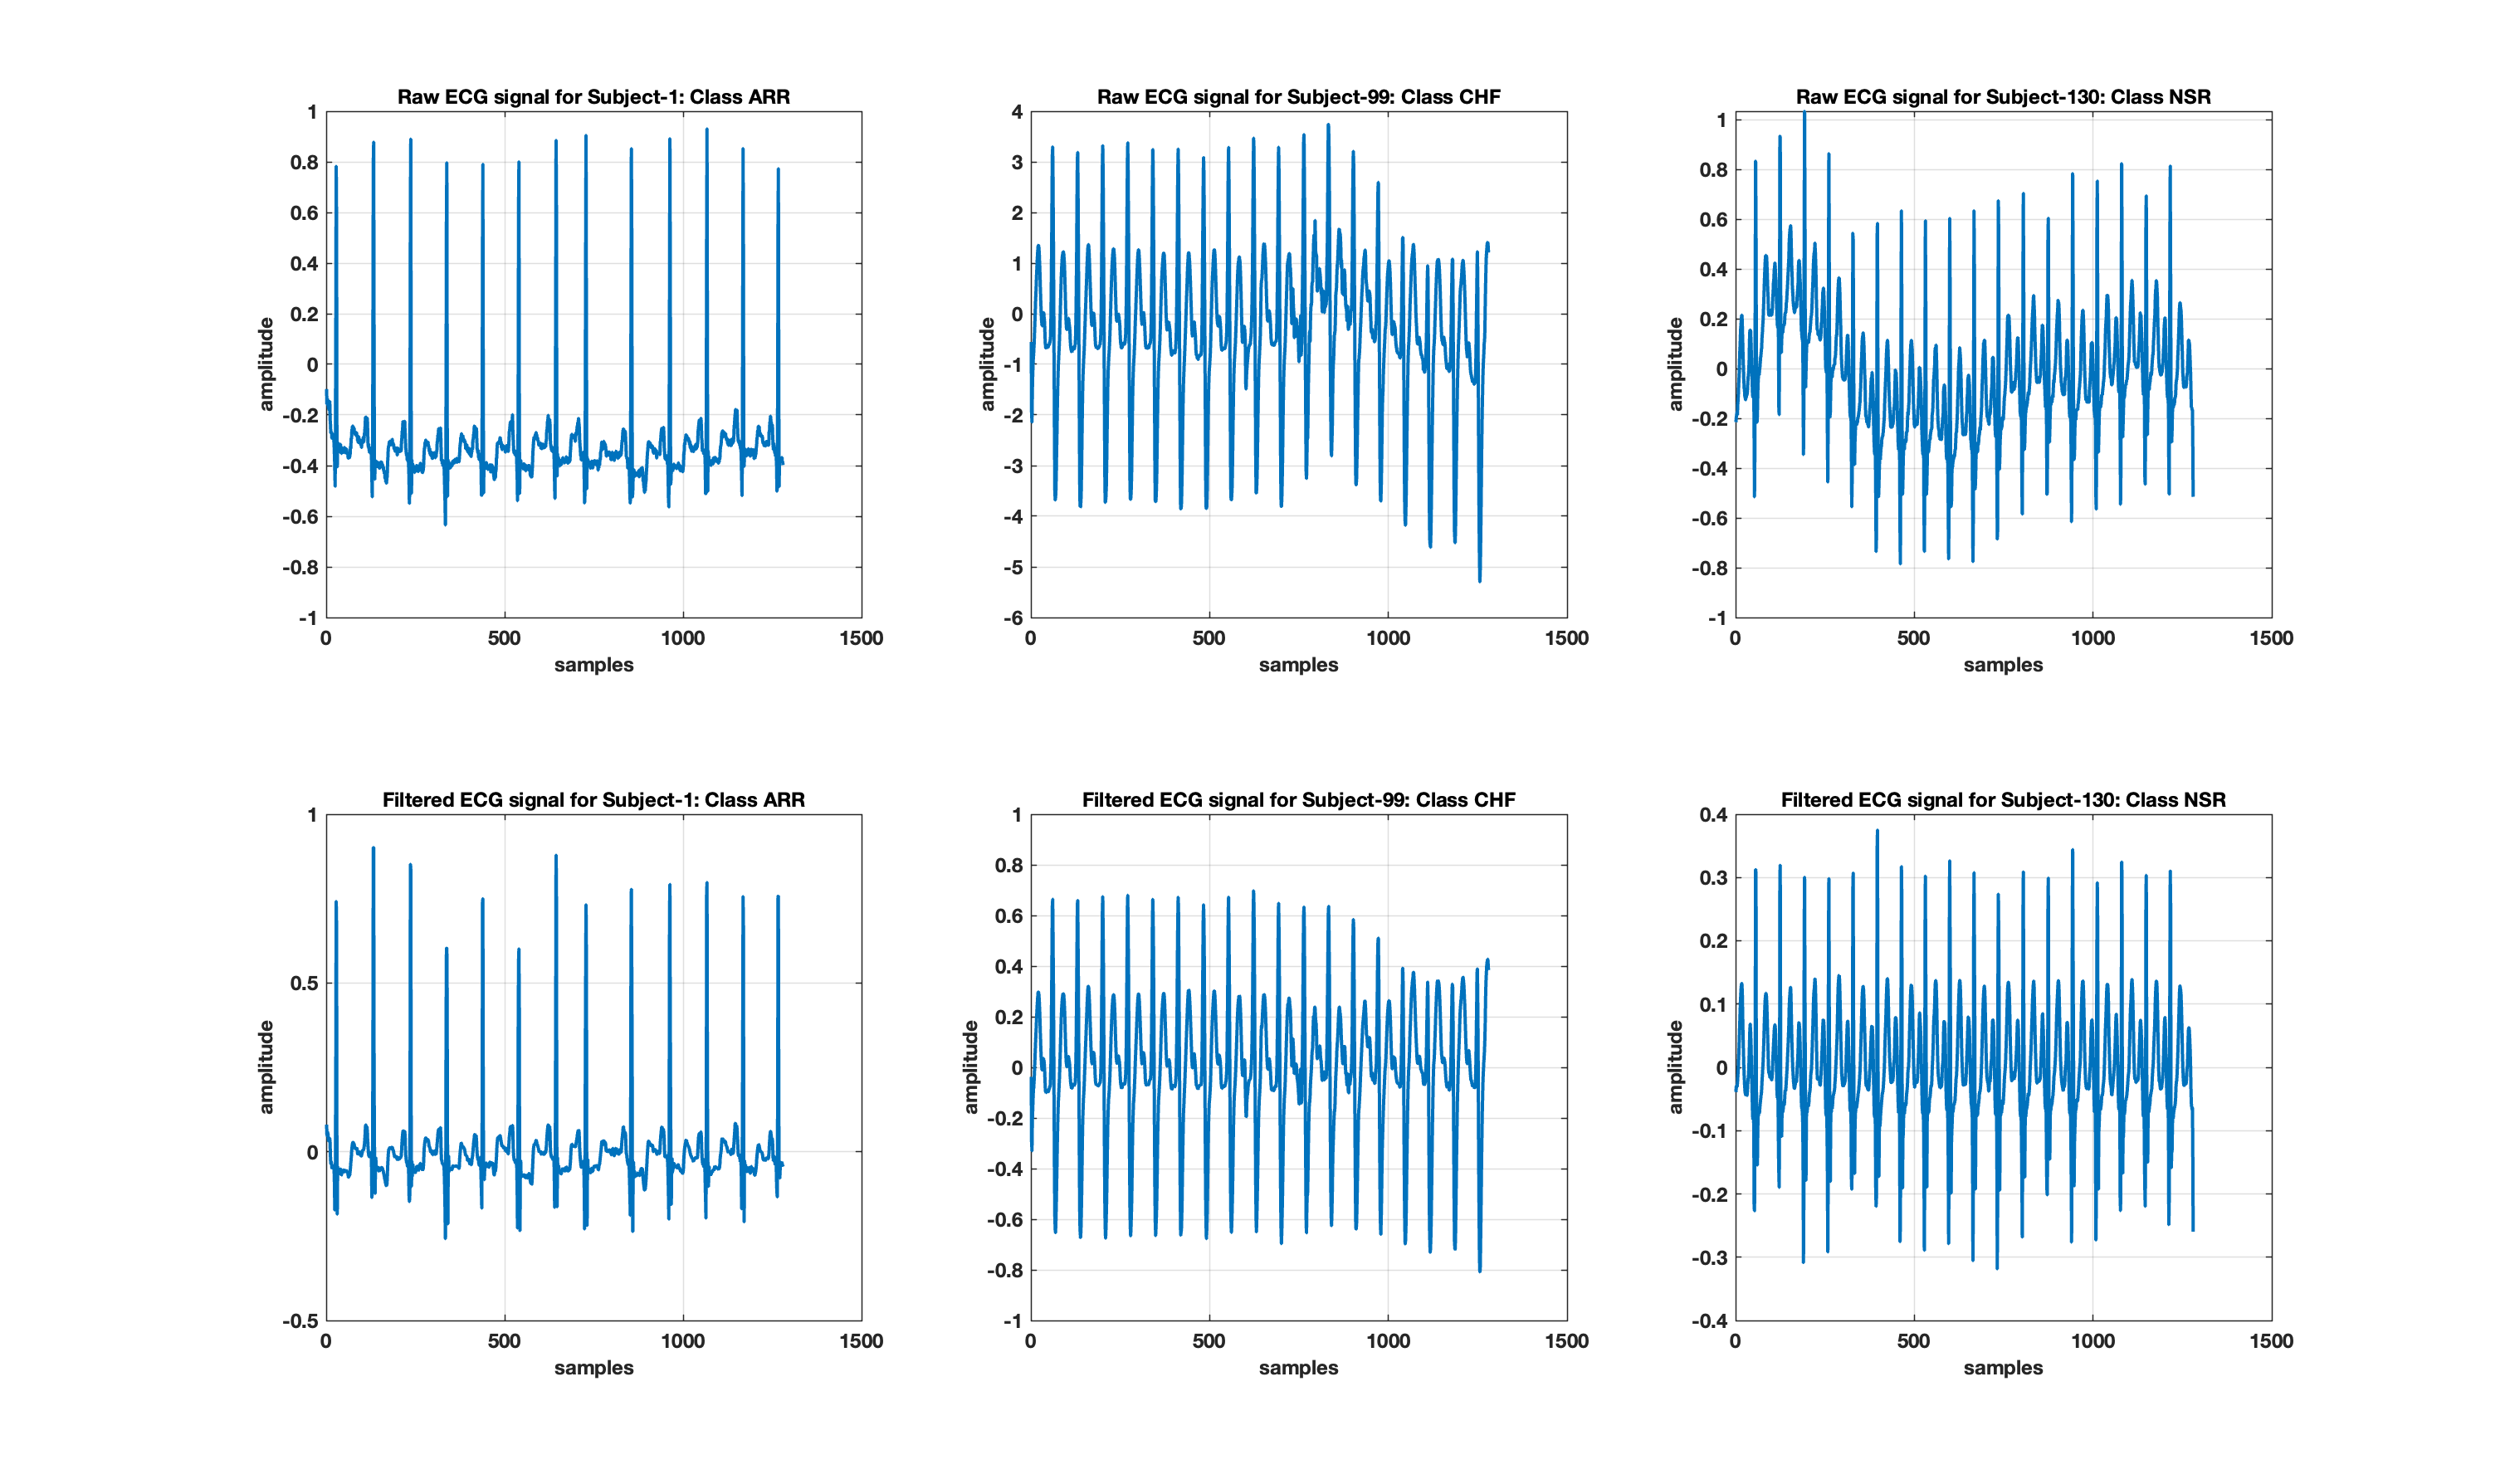

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
from numpy import mean
from numpy import std
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix
from scipy.io import loadmat
import PIL
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [11]:
#load the ECG data from Physionet database
#https://github.com/mathworks/physionet_ECG_data/
data = loadmat("/content/drive/MyDrive/ECG_data/ECG_filtered_data.mat")
dataloaded = np.asarray(data['data'])

In [12]:
dataloaded.shape

(162, 1281)

In [13]:
X=dataloaded[:,0:dataloaded.shape[1]-1]
#print(X)
X.shape

(162, 1280)

In [14]:
y=dataloaded[:,dataloaded.shape[1]-1]
print(y)
y.shape

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]


(162,)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [16]:
#feature scaling
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
print(X_train.shape), print(X_test.shape)
print(y_train.shape), print(y_test.shape)

(129, 1280)
(33, 1280)
(129,)
(33,)


(None, None)

In [18]:
#class imbalance problem
from imblearn.over_sampling import SMOTE
smote= SMOTE(sampling_strategy='minority')
X_sm,y_sm= smote.fit_resample(X_train,y_train)
print(X_sm.shape, y_sm.shape)

(183, 1280) (183,)


# **LGBM Classifier**

In [43]:
import lightgbm as lgb
model_lgbm = lgb.LGBMClassifier(learning_rate=0.15,max_depth=-5,random_state=42)
model_lgbm.fit(X_sm,y_sm,eval_set=[(X_test,y_test),(X_sm,y_sm)],
          verbose=20,eval_metric='logloss')
y_pred = model_lgbm.predict(X_test)
print(confusion_matrix(y_test,y_pred))

cm=pd.crosstab(y_test,y_pred)
accuracy=(np.diag(cm).sum()/cm.sum().sum())*100
print(accuracy)
print(pd.DataFrame(classification_report(y_test,y_pred,output_dict=True)).T)

Kappa=sklearn.metrics.cohen_kappa_score(y_test,y_pred) 
print('Kappa=',Kappa)

[20]	training's multi_logloss: 0.157736	training's multi_logloss: 0.157736	valid_0's multi_logloss: 0.931546	valid_0's multi_logloss: 0.931546
[40]	training's multi_logloss: 0.0280144	training's multi_logloss: 0.0280144	valid_0's multi_logloss: 1.06107	valid_0's multi_logloss: 1.06107
[60]	training's multi_logloss: 0.00535654	training's multi_logloss: 0.00535654	valid_0's multi_logloss: 1.2432	valid_0's multi_logloss: 1.2432
[80]	training's multi_logloss: 0.00104651	training's multi_logloss: 0.00104651	valid_0's multi_logloss: 1.44017	valid_0's multi_logloss: 1.44017
[100]	training's multi_logloss: 0.000199624	training's multi_logloss: 0.000199624	valid_0's multi_logloss: 1.64045	valid_0's multi_logloss: 1.64045
[[16  2  0]
 [ 5  1  1]
 [ 4  0  4]]
63.63636363636363
              precision    recall  f1-score    support
1.0            0.640000  0.888889  0.744186  18.000000
2.0            0.333333  0.142857  0.200000   7.000000
3.0            0.800000  0.500000  0.615385   8.000000
acc

In [44]:
ia1=(cm[1][1]/cm.iloc[0,:].sum())*100 
print('Class-1 accuracy=',ia1)
ia2=(cm[2][2]/cm.iloc[1,:].sum())*100
print('Class-2 accuracy=',ia2)
ia3=(cm[3][3]/cm.iloc[2,:].sum())*100
print('Class-3 accuracy=',ia3)
oa=(ia1+ia2+ia3)/3
print('Overall Accuracy=',oa) 

Class-1 accuracy= 88.88888888888889
Class-2 accuracy= 14.285714285714285
Class-3 accuracy= 50.0
OA= 51.05820105820106


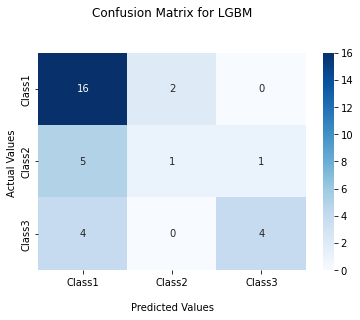

In [45]:
import seaborn as sns

ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix for LGBM\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Class1','Class2', 'Class3'])
ax.yaxis.set_ticklabels(['Class1','Class2', 'Class3'])

## Display the visualization of the Confusion Matrix.
plt.show()

# **Random Forest Classifier**

In [46]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Fitting Random Forest Classification to the Training set
model_rf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
model_rf.fit(X_sm, y_sm)

y_pred = model_rf.predict(X_test)

cm1 = confusion_matrix(y_test, y_pred)
print("confusion matrix \n",cm1)
cm=pd.crosstab(y_test,y_pred)
accuracy=(np.diag(cm).sum()/cm.sum().sum())*100
print(accuracy)
print(pd.DataFrame(classification_report(y_test,y_pred,output_dict=True)).T)

Kappa=sklearn.metrics.cohen_kappa_score(y_test,y_pred) 
print('Kappa=',Kappa)

confusion matrix 
 [[16  2  0]
 [ 6  1  0]
 [ 5  0  3]]
60.60606060606061
              precision    recall  f1-score    support
1.0            0.592593  0.888889  0.711111  18.000000
2.0            0.333333  0.142857  0.200000   7.000000
3.0            1.000000  0.375000  0.545455   8.000000
accuracy       0.606061  0.606061  0.606061   0.606061
macro avg      0.641975  0.468915  0.485522  33.000000
weighted avg   0.636364  0.606061  0.562534  33.000000
Kappa= 0.23118279569892475


In [47]:
ia1=(cm[1][1]/cm.iloc[0,:].sum())*100
print('Class-1 accuracy=',ia1)
ia2=(cm[2][2]/cm.iloc[1,:].sum())*100
print('Class-2 accuracy=',ia2)
ia3=(cm[3][3]/cm.iloc[2,:].sum())*100
print('Class-3 accuracy=',ia3)
oa=(ia1+ia2+ia3)/3
print('Overall Accuracy=',oa)

Class-1 accuracy= 88.88888888888889
Class-2 accuracy= 14.285714285714285
Class-3 accuracy= 37.5
OA= 46.891534391534385


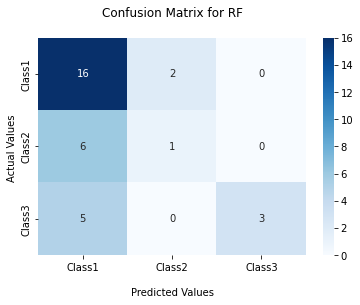

In [48]:
import seaborn as sns

ax = sns.heatmap(cm1, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix for RF\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Class1','Class2', 'Class3'])
ax.yaxis.set_ticklabels(['Class1','Class2', 'Class3'])

## Display the visualization of the Confusion Matrix.
plt.show()

# **XGBoost Classifier**

In [49]:
import xgboost as xgb
from xgboost import XGBClassifier

model_xgb = XGBClassifier() 

model_xgb.fit(X_sm, y_sm)

y_pred = model_xgb.predict(X_test)

cm1 = confusion_matrix(y_test, y_pred)
print("confusion matrix \n",cm1)

cm=pd.crosstab(y_test,y_pred)
accuracy=(np.diag(cm).sum()/cm.sum().sum())*100
print(accuracy)
print(pd.DataFrame(classification_report(y_test,y_pred,output_dict=True)).T)

Kappa=sklearn.metrics.cohen_kappa_score(y_test,y_pred) 
print('Kappa=',Kappa)

confusion matrix 
 [[14  4  0]
 [ 5  1  1]
 [ 6  0  2]]
51.515151515151516
              precision    recall  f1-score    support
1.0            0.560000  0.777778  0.651163  18.000000
2.0            0.200000  0.142857  0.166667   7.000000
3.0            0.666667  0.250000  0.363636   8.000000
accuracy       0.515152  0.515152  0.515152   0.515152
macro avg      0.475556  0.390212  0.393822  33.000000
weighted avg   0.509495  0.515152  0.478688  33.000000
Kappa= 0.08965517241379306


In [50]:
ia1=(cm[1][1]/cm.iloc[0,:].sum())*100
print('Class-1 accuracy=',ia1)
ia2=(cm[2][2]/cm.iloc[1,:].sum())*100
print('Class-2 accuracy=',ia2)
ia3=(cm[3][3]/cm.iloc[2,:].sum())*100
print('Class-3 accuracy=',ia3)
oa=(ia1+ia2+ia3)/3
print('Overall Accuracy=',oa)

Class-1 accuracy= 77.77777777777779
Class-2 accuracy= 14.285714285714285
Class-3 accuracy= 25.0
OA= 39.021164021164026


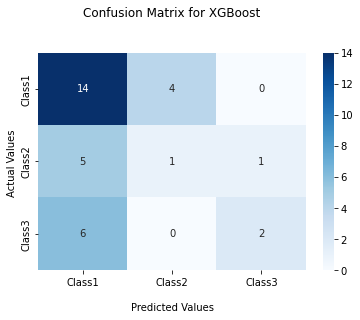

In [51]:
import seaborn as sns

ax = sns.heatmap(cm1, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix for XGBoost\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Class1','Class2', 'Class3'])
ax.yaxis.set_ticklabels(['Class1','Class2', 'Class3'])

## Display the visualization of the Confusion Matrix.
plt.show()

# **KNN Classifier**

In [53]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_sm, y_sm)
knn.score(X_test, y_test)

y_pred = knn.predict(X_test)

acc=accuracy_score(y_test, y_pred)
cm1 = confusion_matrix(y_test, y_pred)
print("confusion matrix \n",cm1)

cm=pd.crosstab(y_test,y_pred)
accuracy=(np.diag(cm).sum()/cm.sum().sum())*100
print(accuracy)
print(pd.DataFrame(classification_report(y_test,y_pred,output_dict=True)).T)

Kappa=sklearn.metrics.cohen_kappa_score(y_test,y_pred) 
print('Kappa=',Kappa)

confusion matrix 
 [[ 0 18  0]
 [ 0  7  0]
 [ 2  5  1]]
24.242424242424242
              precision    recall  f1-score    support
1.0            0.000000  0.000000  0.000000  18.000000
2.0            0.233333  1.000000  0.378378   7.000000
3.0            1.000000  0.125000  0.222222   8.000000
accuracy       0.242424  0.242424  0.242424   0.242424
macro avg      0.411111  0.375000  0.200200  33.000000
weighted avg   0.291919  0.242424  0.134134  33.000000
Kappa= 0.011976047904191711


In [54]:
ia1=(cm[1][1]/cm.iloc[0,:].sum())*100
print('Class-1 accuracy=',ia1)
ia2=(cm[2][2]/cm.iloc[1,:].sum())*100
print('Class-2 accuracy=',ia2)
ia3=(cm[3][3]/cm.iloc[2,:].sum())*100
print('Class-3 accuracy=',ia3)
oa=(ia1+ia2+ia3)/3
print('Overall Accuracy=',oa)

Class-1 accuracy= 0.0
Class-2 accuracy= 100.0
Class-3 accuracy= 12.5
OA= 37.5


# **Decision Tree Classifier**

In [55]:
from sklearn.tree import DecisionTreeClassifier

***perform training with giniIndex.***

In [56]:
#perform training with giniIndex.
clf_gini = DecisionTreeClassifier(criterion = "gini",
          random_state = 100,max_depth=6, min_samples_leaf=6)
  
# Performing training
clf_gini.fit(X_sm, y_sm)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=6, random_state=100)

In [57]:
y_pred = clf_gini.predict(X_test)
print(y_pred)

[1. 3. 1. 3. 1. 1. 1. 1. 2. 2. 3. 3. 1. 3. 1. 1. 1. 1. 3. 3. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 3. 1. 1.]


In [59]:
print("Results using Gini Index")
cm1 = confusion_matrix(y_test, y_pred)
print("confusion matrix \n",cm1)

cm=pd.crosstab(y_test,y_pred)
accuracy=(np.diag(cm).sum()/cm.sum().sum())*100
print(accuracy)
print(pd.DataFrame(classification_report(y_test,y_pred,output_dict=True)).T)

Kappa=sklearn.metrics.cohen_kappa_score(y_test,y_pred) 
print('Kappa=',Kappa)

Results using Gini Index
confusion matrix 
 [[15  1  2]
 [ 5  1  1]
 [ 3  0  5]]
63.63636363636363
              precision    recall  f1-score    support
1.0            0.652174  0.833333  0.731707  18.000000
2.0            0.500000  0.142857  0.222222   7.000000
3.0            0.625000  0.625000  0.625000   8.000000
accuracy       0.636364  0.636364  0.636364   0.636364
macro avg      0.592391  0.533730  0.526310  33.000000
weighted avg   0.613307  0.636364  0.597766  33.000000
Kappa= 0.33668341708542726


In [60]:
ia1=(cm[1][1]/cm.iloc[0,:].sum())*100
print('Class-1 accuracy=',ia1)
ia2=(cm[2][2]/cm.iloc[1,:].sum())*100
print('Class-2 accuracy=',ia2)
ia3=(cm[3][3]/cm.iloc[2,:].sum())*100
print('Class-3 accuracy=',ia3)
oa=(ia1+ia2+ia3)/3
print('Overall Accuracy=',oa)

Class-1 accuracy= 83.33333333333334
Class-2 accuracy= 14.285714285714285
Class-3 accuracy= 62.5
OA= 53.37301587301587


***perform training with Entropy.***

In [61]:
#perform training with entropy.
clf_entropy = DecisionTreeClassifier(
            criterion = "entropy", random_state = 100,
            max_depth = 6, min_samples_leaf = 6)

# Performing training
clf_entropy.fit(X_sm, y_sm)

DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=6,
                       random_state=100)

In [62]:
y_pred = clf_entropy.predict(X_test)
print(y_pred)

[3. 3. 1. 3. 2. 1. 1. 1. 2. 1. 3. 1. 1. 3. 1. 1. 1. 1. 3. 3. 3. 1. 1. 1.
 2. 3. 1. 1. 1. 1. 3. 3. 1.]


In [63]:
print("Results using Entropy")
cm1 = confusion_matrix(y_test, y_pred)
print("confusion matrix \n",cm1)

cm=pd.crosstab(y_test,y_pred)
accuracy=(np.diag(cm).sum()/cm.sum().sum())*100
print(accuracy)
print(pd.DataFrame(classification_report(y_test,y_pred,output_dict=True)).T)

Kappa=sklearn.metrics.cohen_kappa_score(y_test,y_pred) 
print('Kappa=',Kappa)

Results using Entropy
confusion matrix 
 [[10  3  5]
 [ 6  0  1]
 [ 3  0  5]]
45.45454545454545
              precision    recall  f1-score    support
1.0            0.526316  0.555556  0.540541  18.000000
2.0            0.000000  0.000000  0.000000   7.000000
3.0            0.454545  0.625000  0.526316   8.000000
accuracy       0.454545  0.454545  0.454545   0.454545
macro avg      0.326954  0.393519  0.355619  33.000000
weighted avg   0.397274  0.454545  0.422432  33.000000
Kappa= 0.06896551724137945


In [64]:
ia1=(cm[1][1]/cm.iloc[0,:].sum())*100
print('Class-1 accuracy=',ia1)
ia2=(cm[2][2]/cm.iloc[1,:].sum())*100
print('Class-2 accuracy=',ia2)
ia3=(cm[3][3]/cm.iloc[2,:].sum())*100
print('Class-3 accuracy=',ia3)
oa=(ia1+ia2+ia3)/3
print('Overall Accuracy=',oa)

Class-1 accuracy= 55.55555555555556
Class-2 accuracy= 0.0
Class-3 accuracy= 62.5
OA= 39.351851851851855


# **Extremely Randomized Trees Classifier(Extra Trees Classifier):**


*   ***Extremely Randomized Trees Classifier(Extra Trees Classifier) is a type of ensemble learning technique which aggregates the results of multiple de-correlated decision trees collected in a “forest” to output it’s classification result. In concept, it is very similar to a Random Forest Classifier and only differs from it in the manner of construction of the decision trees in the forest.***




In [65]:
from sklearn.ensemble import ExtraTreesClassifier

In [66]:
# Building the model
extra_tree_forest = ExtraTreesClassifier(n_estimators=25, criterion='gini', max_features='auto', bootstrap=False)
  
# Training the model
extra_tree_forest.fit(X_sm, y_sm)

ExtraTreesClassifier(n_estimators=25)

In [67]:
y_pred = extra_tree_forest.predict(X_test)
print(y_pred)

[1. 3. 1. 1. 1. 1. 1. 1. 1. 1. 3. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 2. 1. 1. 1.]


In [68]:
print("Results using Extremely Randomized Trees Classifier(Extra Trees Classifier)")
cm1 = confusion_matrix(y_test, y_pred)
print("confusion matrix \n",cm1)

cm=pd.crosstab(y_test,y_pred)
accuracy=(np.diag(cm).sum()/cm.sum().sum())*100
print(accuracy)
print(pd.DataFrame(classification_report(y_test,y_pred,output_dict=True)).T)

Kappa=sklearn.metrics.cohen_kappa_score(y_test,y_pred) 
print('Kappa=',Kappa)

Results using Extremely Randomized Trees Classifier(Extra Trees Classifier)
confusion matrix 
 [[17  1  0]
 [ 6  1  0]
 [ 6  0  2]]
60.60606060606061
              precision    recall  f1-score    support
1.0            0.586207  0.944444  0.723404  18.000000
2.0            0.500000  0.142857  0.222222   7.000000
3.0            1.000000  0.250000  0.400000   8.000000
accuracy       0.606061  0.606061  0.606061   0.606061
macro avg      0.695402  0.445767  0.448542  33.000000
weighted avg   0.668234  0.606061  0.538692  33.000000
Kappa= 0.2011173184357542


In [69]:
ia1=(cm[1][1]/cm.iloc[0,:].sum())*100
print('Class-1 accuracy=',ia1)
ia2=(cm[2][2]/cm.iloc[1,:].sum())*100
print('Class-2 accuracy=',ia2)
ia3=(cm[3][3]/cm.iloc[2,:].sum())*100
print('Class-3 accuracy=',ia3)
oa=(ia1+ia2+ia3)/3
print('Overall Accuracy=',oa)

Class-1 accuracy= 94.44444444444444
Class-2 accuracy= 14.285714285714285
Class-3 accuracy= 25.0
OA= 44.576719576719576


# **AdaBoost Classifier**

In [70]:
from sklearn.ensemble import AdaBoostClassifier



*   Using Different Base Learners
I have used RF as a base estimator. You can use any ML learner as base estimator if it accepts sample weight such as Decision Tree, Support Vector Classifier.



In [71]:
# Import Support Vector Classifier
#from sklearn.svm import SVC
#Import scikit-learn metrics module for accuracy calculation
#from sklearn import metrics
#svc=SVC(probability=True, kernel='linear')

rf = RandomForestClassifier(n_estimators = 40, criterion = 'entropy', random_state = 42)
# Create adaboost classifer object
abc =AdaBoostClassifier(n_estimators=50, base_estimator=rf,learning_rate=1)

# Train Adaboost Classifer
model_abc = abc.fit(X_sm, y_sm)

#Predict the response for test dataset
y_pred = model_abc.predict(X_test)

In [72]:
print("Results using AdaBoost Classifier with different base learners")
cm1 = confusion_matrix(y_test, y_pred)
print("confusion matrix \n",cm1)

cm=pd.crosstab(y_test,y_pred)
accuracy=(np.diag(cm).sum()/cm.sum().sum())*100
print(accuracy)
print(pd.DataFrame(classification_report(y_test,y_pred,output_dict=True)).T)

Kappa=sklearn.metrics.cohen_kappa_score(y_test,y_pred) 
print('Kappa=',Kappa)

Results using AdaBoost Classifier with different base learners
confusion matrix 
 [[15  3  0]
 [ 7  0  0]
 [ 6  0  2]]
51.515151515151516
              precision    recall  f1-score    support
1.0            0.535714  0.833333  0.652174  18.000000
2.0            0.000000  0.000000  0.000000   7.000000
3.0            1.000000  0.250000  0.400000   8.000000
accuracy       0.515152  0.515152  0.515152   0.515152
macro avg      0.511905  0.361111  0.350725  33.000000
weighted avg   0.534632  0.515152  0.452701  33.000000
Kappa= 0.03649635036496346


In [73]:
ia1=(cm[1][1]/cm.iloc[0,:].sum())*100
print('Class-1 accuracy=',ia1)
ia2=(cm[2][2]/cm.iloc[1,:].sum())*100
print('Class-2 accuracy=',ia2)
ia3=(cm[3][3]/cm.iloc[2,:].sum())*100
print('Class-3 accuracy=',ia3)
oa=(ia1+ia2+ia3)/3
print('Overall Accuracy=',oa)

Class-1 accuracy= 83.33333333333334
Class-2 accuracy= 0.0
Class-3 accuracy= 25.0
OA= 36.111111111111114


# DEEP FOREST CLASSIFIER
https://github.com/LAMDA-NJU/Deep-Forest

In [74]:
pip install deep-forest

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 28.3 MB/s eta 0:00:00


In [75]:
from deepforest import CascadeForestClassifier

In [76]:
model = CascadeForestClassifier(random_state=1)
model.fit(X_sm, y_sm)
y_pred = model.predict(X_test)

[2023-02-17 06:37:00.610] Start to fit the model:
[2023-02-17 06:37:00.610] Fitting cascade layer = 0 
[2023-02-17 06:37:02.762] layer = 0  | Val Acc = 81.967 % | Elapsed = 2.152 s
[2023-02-17 06:37:02.766] Fitting cascade layer = 1 
[2023-02-17 06:37:03.929] layer = 1  | Val Acc = 81.967 % | Elapsed = 1.163 s
[2023-02-17 06:37:03.929] Early stopping counter: 1 out of 2
[2023-02-17 06:37:03.932] Fitting cascade layer = 2 
[2023-02-17 06:37:04.805] layer = 2  | Val Acc = 83.060 % | Elapsed = 0.873 s
[2023-02-17 06:37:04.807] Fitting cascade layer = 3 
[2023-02-17 06:37:05.693] layer = 3  | Val Acc = 81.421 % | Elapsed = 0.886 s
[2023-02-17 06:37:05.694] Early stopping counter: 1 out of 2
[2023-02-17 06:37:05.696] Fitting cascade layer = 4 
[2023-02-17 06:37:06.606] layer = 4  | Val Acc = 83.060 % | Elapsed = 0.910 s
[2023-02-17 06:37:06.607] Early stopping counter: 2 out of 2
[2023-02-17 06:37:06.608] Handling early stopping
[2023-02-17 06:37:06.609] The optimal number of layers: 3
[202

In [77]:
print("Results using Deep forest classifier")
cm1 = confusion_matrix(y_test, y_pred)
print("confusion matrix \n",cm1)

cm=pd.crosstab(y_test,y_pred)
accuracy=(np.diag(cm).sum()/cm.sum().sum())*100
print(accuracy)
print(pd.DataFrame(classification_report(y_test,y_pred,output_dict=True)).T)

Kappa=sklearn.metrics.cohen_kappa_score(y_test,y_pred) 
print('Kappa=',Kappa)

Results using Deep forest classifier
confusion matrix 
 [[18  0  0]
 [ 7  0  0]
 [ 5  0  3]]
54.54545454545454
              precision    recall  f1-score    support
1.0            0.600000  1.000000  0.750000  18.000000
2.0            0.000000  0.000000  0.000000   7.000000
3.0            1.000000  0.375000  0.545455   8.000000
accuracy       0.636364  0.636364  0.636364   0.636364
macro avg      0.533333  0.458333  0.431818  33.000000
weighted avg   0.569697  0.636364  0.541322  33.000000
Kappa= 0.24571428571428577


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
